In [2]:
import re
import os
import subprocess
from collections import defaultdict
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

In [3]:
from sklearn.preprocessing import StandardScaler
from Bio import AlignIO

In [4]:
hmm_path = '/nethome/kgeorge/workspace/DomainPrediction/hmm'
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data'

In [5]:
tm_path = './nethome/kgeorge/workspace/DomainPrediction/src/utils/TMalign'
class TMalign():
    def __init__(self, path) -> None:
        self.tmalign = path

    def run(self, prot_a, prot_b):
        out = subprocess.check_output([self.tmalign, prot_a, prot_b])
        data = str(out).split("\\n")
        for d in data:
            x = re.sub(r"\s\s+", " ", d).split(' ')
            if x[0] == 'Aligned':
                rmsd = float(x[4][:-1])
                seq_id = float(x[6])
            elif x[0] == 'TM-score=':
                tm_score = float(x[1])
                break

        return {
            'rmsd': rmsd,
            'seq_id': seq_id,
            'tm_score': tm_score
        }

In [6]:
class HmmerTools():
    def __init__(self) -> None:
        self.scaler = StandardScaler()

    def hmmalign(self, hmm_path: str, fasta_file: str, 
                  outfile: str | None = None, 
                  trim: bool = False):
        if outfile is None:
            outfile = fasta_file.replace('.fasta', '.stockholm')

        if trim:
            with open(outfile, "w") as fout:
                subprocess.run(['hmmalign', '--trim', hmm_path, fasta_file], stdout=fout)
        else:
            with open(outfile, "w") as fout:
                subprocess.run(['hmmalign', hmm_path, fasta_file], stdout=fout)

        print(f'alignment created: {outfile}')


    def parse_hmmsearch_tblout(self, filename):
        with open(filename) as fin:
            tmp = []
            for line in fin:
                if not line.startswith('#'):
                    tmp.append(line.strip().split()[:7])

        df = pd.DataFrame(tmp, columns=['name', '-', 'domain', 'domain_id', 'Evalue', 'score', 'bias'])
        df['Evalue'] = df['Evalue'].astype(float)
        df['score'] = df['score'].astype(float)
        df['bias'] = df['bias'].astype(float)

        return df

    def sort_by_Eval(self, df, top=None):
        df_tmp = df[['name']].drop_duplicates().sort_values(by=['name']).reset_index(drop=True)
        
        for domain in df['domain'].unique():
            print(f'domain {domain} {df[df["domain"] == domain].shape[0]}')
            df_tmp[domain] = df[df['domain'] == domain].sort_values(by=['name'])['Evalue'].to_numpy()

        df_tmp['sum'] = df_tmp[df['domain'].unique()].sum(axis=1)

        df_tmp['norm_sum'] = self.scaler.fit_transform(df_tmp[df['domain'].unique()]).sum(axis=1)

        df_sorted = df_tmp.sort_values(by=['norm_sum'])
        if top is None:
            return df_sorted['name'].to_numpy()
        else:
            return df_sorted['name'].to_numpy()[:top]
        
    def sort_by_Eval_domain(self, df, domain, top=None):

        df_tmp = df[df['domain'] == domain]
        df_sorted = df_tmp.sort_values(by=['Evalue'])

        if top is None:
            return df_sorted['name'].to_numpy()
        else:
            return df_sorted['name'].to_numpy()[:top]

In [7]:
class AlignTools():
    def __init__(self, path: str) -> None:
        self.align = AlignIO.read(path, "stockholm")
    
    def show_alignment(self):
        print(self.align)

    def get_alignment_length(self):
        return self.align.get_alignment_length()
    
    def get_num_sequences(self):
        return len(self.align)

    def get_pairwise_identity(self):
        pairwise_seqid = np.eye(self.get_num_sequences())

        for i, record_1 in enumerate(self.align):
            for j, record_2 in enumerate(self.align):
                seq_id = 0
                for s1, s2 in zip(record_1.seq, record_2.seq):
                    if s1 != '-' and s2 != '-' and s1 != '.' and s2 != '.' and s1 == s2:
                        seq_id += 1

                pairwise_seqid[i,j] = seq_id/self.get_alignment_length()

        return pairwise_seqid

In [8]:
tmalign = TMalign(tm_path)
hmmer = HmmerTools()

In [9]:
pfam_T_hmm = '/nethome/kgeorge/workspace/DomainPrediction/hmm/PF00550_T.hmm'
fasta_loc = os.path.join(data_path, 'esm_experiments/basic_gen/esm_inp_seq_gen_gpu.fasta')
hmmer.hmmalign(hmm_path=pfam_T_hmm, fasta_file=fasta_loc, trim=True)

alignment created: /nethome/kgeorge/workspace/DomainPrediction/Data/esm_experiments/basic_gen/esm_inp_seq_gen_gpu.stockholm


In [10]:
pfam_T_hmm = '/nethome/kgeorge/workspace/DomainPrediction/hmm/PF00550_T.hmm'
fasta_loc = os.path.join(data_path, 'esm_experiments/basic_gen/esm_inp_seq_str_gen_gpu.fasta')
hmmer.hmmalign(hmm_path=pfam_T_hmm, fasta_file=fasta_loc, trim=True)

alignment created: /nethome/kgeorge/workspace/DomainPrediction/Data/esm_experiments/basic_gen/esm_inp_seq_str_gen_gpu.stockholm


In [11]:
pfam_T_hmm = '/nethome/kgeorge/workspace/DomainPrediction/hmm/PF00550_T.hmm'
fasta_loc = os.path.join(data_path, 'pmpnn_experiments/selected_100/Gxps_selected_100.fasta')
hmmer.hmmalign(hmm_path=pfam_T_hmm, fasta_file=fasta_loc, trim=True)

alignment created: /nethome/kgeorge/workspace/DomainPrediction/Data/pmpnn_experiments/selected_100/Gxps_selected_100.stockholm


In [12]:
align_esm_seq = AlignTools(os.path.join(data_path, 'esm_experiments/basic_gen/esm_inp_seq_gen_gpu.stockholm'))
align_esm_seq_str = AlignTools(os.path.join(data_path, 'esm_experiments/basic_gen/esm_inp_seq_str_gen_gpu.stockholm'))
align_pmpnn_100 = AlignTools(os.path.join(data_path, 'pmpnn_experiments/selected_100/Gxps_selected_100.stockholm'))

In [13]:
align_esm_seq.get_num_sequences(), align_esm_seq_str.get_num_sequences(), align_pmpnn_100.get_num_sequences()

(101, 101, 101)

In [14]:
# wrt to original. original at 0 
align_esm_seq.get_pairwise_identity()[0][1:]

array([0.47761194, 0.46268657, 0.44776119, 0.52238806, 0.52238806,
       0.43283582, 0.43283582, 0.44776119, 0.43283582, 0.41791045,
       0.40298507, 0.44776119, 0.49253731, 0.43283582, 0.47761194,
       0.43283582, 0.46268657, 0.50746269, 0.44776119, 0.47761194,
       0.43283582, 0.47761194, 0.46268657, 0.43283582, 0.49253731,
       0.50746269, 0.41791045, 0.43283582, 0.37313433, 0.43283582,
       0.47761194, 0.49253731, 0.41791045, 0.40298507, 0.49253731,
       0.47761194, 0.46268657, 0.50746269, 0.52238806, 0.47761194,
       0.44776119, 0.47761194, 0.47761194, 0.43283582, 0.46268657,
       0.43283582, 0.46268657, 0.46268657, 0.47761194, 0.52238806,
       0.50746269, 0.43283582, 0.46268657, 0.47761194, 0.49253731,
       0.52238806, 0.46268657, 0.47761194, 0.47761194, 0.43283582,
       0.52238806, 0.52238806, 0.46268657, 0.46268657, 0.43283582,
       0.41791045, 0.47761194, 0.46268657, 0.46268657, 0.43283582,
       0.44776119, 0.46268657, 0.40298507, 0.47761194, 0.49253

In [15]:
# all pairwise except original
align_esm_seq.get_pairwise_identity()[1:,1:][np.triu_indices(5, k = 1)]

array([0.6119403 , 0.56716418, 0.62686567, 0.64179104, 0.71641791,
       0.73134328, 0.71641791, 0.67164179, 0.62686567, 0.71641791])

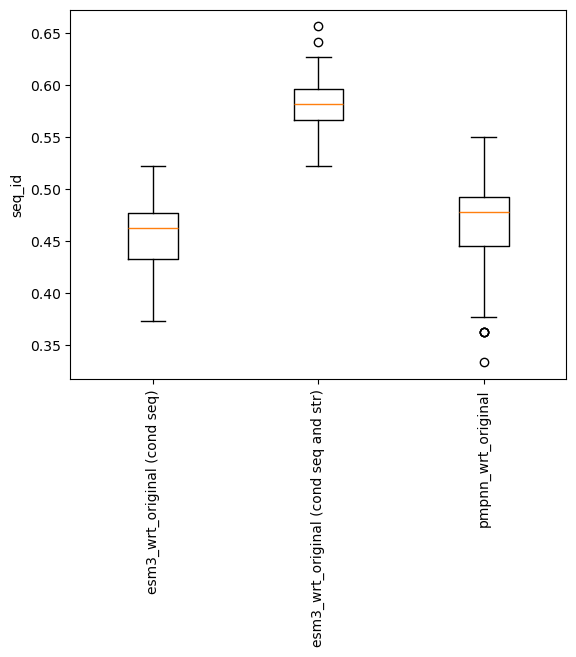

In [17]:
fig, ax = plt.subplots()
_ = ax.boxplot([align_esm_seq.get_pairwise_identity()[0][1:], 
                align_esm_seq_str.get_pairwise_identity()[0][1:], 
                align_pmpnn_100.get_pairwise_identity()[0][1:]],
               labels=['esm3_wrt_original (cond seq)', 'esm3_wrt_original (cond seq + str)', 'pmpnn_wrt_original'])
ax.set_ylabel('seq_id')
ax.tick_params(axis='x', labelrotation=90)

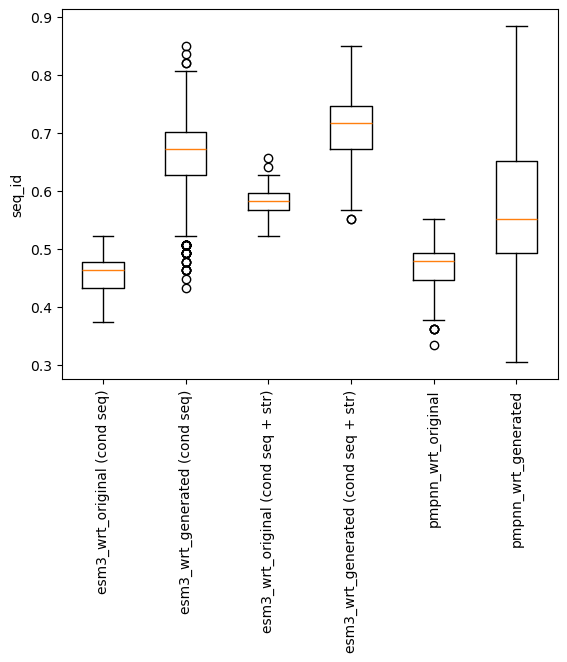

In [18]:
fig, ax = plt.subplots()
_ = ax.boxplot([align_esm_seq.get_pairwise_identity()[0][1:], align_esm_seq.get_pairwise_identity()[1:,1:][np.triu_indices(align_esm_seq.get_num_sequences()-2, k = 1)], 
                align_esm_seq_str.get_pairwise_identity()[0][1:], align_esm_seq_str.get_pairwise_identity()[1:,1:][np.triu_indices(align_esm_seq_str.get_num_sequences()-2, k = 1)], 
                align_pmpnn_100.get_pairwise_identity()[0][1:], align_pmpnn_100.get_pairwise_identity()[1:,1:][np.triu_indices(align_pmpnn_100.get_num_sequences()-2, k = 1)]],
               labels=['esm3_wrt_original (cond seq)', 'esm3_wrt_generated (cond seq)', 'esm3_wrt_original (cond seq + str)', 'esm3_wrt_generated (cond seq + str)', 'pmpnn_wrt_original', 'pmpnn_wrt_generated'])
ax.set_ylabel('seq_id')
ax.tick_params(axis='x', labelrotation=90)

In [19]:
align_esm_seq.show_alignment()

Alignment with 101 rows and 67 columns
--LATIWRELLNVEQ--VGRHDSFFALGGHSLLAVRMIERLRRI...Q-- GxpS_ATC
-VLAAIWADVLGIEQ--VGIHDNFFELGGDSLLATQVIARVRQA...QVI GxpS_ATC-temp_0.5-gen_0
-RLAEIWQELLGVE--RIGIHDNFFELGGHSILAIQLVARIRQT...ARL GxpS_ATC-temp_0.5-gen_1
QALADIWSEVLGIE--RIGIHDNFFDLGGHSILAIQLVSRIRAR...QRV GxpS_ATC-temp_0.5-gen_2
-LLAGIWCEVLNVE--RVGRHDNFFELGGHSILAIQLISRIRTA...ARI GxpS_ATC-temp_0.5-gen_3
EQLAAIWAELLRVE--RVGIHDNFFELGGHSILAIQVISRVRAT...ARL GxpS_ATC-temp_0.5-gen_4
-TVAGIWAELLGLEQ--VGVHDNFFELGGDSILSIQLVARIREA...AE- GxpS_ATC-temp_0.5-gen_5
-LLAGIWTEVLGLD--RIGIHDNFFELGGHSILAIRVTARIRQA...ARI GxpS_ATC-temp_0.5-gen_6
--LTAIWVELLGLE--RVGVHDNFFELGGHSILAVQLVARVRET...ERL GxpS_ATC-temp_0.5-gen_7
-VLAAVWQEILGLD--RIGIHDNFFELGGHSILAIQLVARIRST...ARI GxpS_ATC-temp_0.5-gen_8
-VLAGIWAELLGLE--RVGIHDNFFELGGDSILSIRLVSRIRAA...ALI GxpS_ATC-temp_0.5-gen_9
ETLVEIWRQVLGLD--RVGVHDNFFELGGDSIKAIQVIARVRTA...ARI GxpS_ATC-temp_0.5-gen_10
-VLAEIWAELLGLE--RVGVHDNFFELGGHSILATQVLSRVRSA...ERI GxpS_ATC-temp_0.5-gen_11

In [20]:
align_esm_seq_str.show_alignment()

Alignment with 101 rows and 67 columns
--LATIWRELLNVEQ--VGRHDSFFALGGHSLLAVRMIERLRRI...Q-- GxpS_ATC
-LLAEIWQELLGVE--RVGRHDSFFELGGHSILATRMLNRLRKA...AAL GxpS_ATC-temp_0.5-gen_0
-LLASIWCDLLQVE--RVGRHDNFFALGGHSLLAIKLLSRLREH...AAV GxpS_ATC-temp_0.5-gen_1
-LLAGIWMELLNVEK--VGRHDNFFELGGHSLLAVRMLTRLRQH...TRL GxpS_ATC-temp_0.5-gen_2
-LLAGIWQELLKVD--RVGRDDDFFALGGHSILAIQLLNRLREH...QRL GxpS_ATC-temp_0.5-gen_3
--LAGIWQELLGVE--RVGRYDNFFELGGHSLLAIRLLARLKSQ...ERL GxpS_ATC-temp_0.5-gen_4
QTLAGIWQELLGVE--RVGRHDNFFELGGHSLLAVRMLSRLQKQ...EAI GxpS_ATC-temp_0.5-gen_5
QTLAGIWMELLGVE--RVGRHDSFFALGGHSLLATRLLARLREQ...ARL GxpS_ATC-temp_0.5-gen_6
QTLAAIWQELLEVE--RVGRHDNFFDLGGHSILAIRLMARLREQ...ERL GxpS_ATC-temp_0.5-gen_7
-LLAQVWQELLGVE--RVGRHDNFFALGGHSLLATQLLQRLRAQ...QAL GxpS_ATC-temp_0.5-gen_8
--LAAIWQELLAVE--RVGRNDSFFELGGHSLLATQLLQRLRAQ...QRL GxpS_ATC-temp_0.5-gen_9
-LLAGIWMDLLQVD--RVGRHDSFFELGGHSLLAVRLLGRLRQH...TRL GxpS_ATC-temp_0.5-gen_10
-LLAQIWQELLGVE--RVGRTDNFFELGGHSLLAIRMIARLRAH...QRL GxpS_ATC-temp_0.5-gen_11

In [21]:
align_pmpnn_100.show_alignment()

Alignment with 101 rows and 69 columns
--LATIWRELLNV--EQ--VGRHDSFFALGGHSLLAVRMIERLR...Q-- GxpS_ATC
--LAALLEDILGV--E--EVGARDRFFDLGGHSPLVIRLIGALE...ARL GxpS_ATC-v_48_020-temp_0.7-gen-122
-LLASLLSELLDV--P--RVGLNDSFFALGGHSSKAVRLIEALH...K-- GxpS_ATC-v_48_002-temp_0.3-gen-112
---ADLLRRLLGV--E--RVGANDSFLNLGGHSVKAIALMEALR...RRL GxpS_ATC-v_48_020-temp_0.7-gen-184
-LLAALLERLLGV--P--RVGAGDSFFALGGDSRLVRKLIEELR...KLL GxpS_ATC-v_48_020-temp_0.3-gen-39
-LLAGLLRELLDV--PV--VGANDSFFQLGGDSDLAVKLIEALH...K-- GxpS_ATC-v_48_002-temp_0.5-gen-30
-LLAAILERLLGV--P--RVGAGDSFFALGGDSVRVTALRQALD...ARL GxpS_ATC-v_48_020-temp_0.5-gen-63
-LLADLLRRILHV--PQ--VGANDRFFALGGESEKAVRLIHALR...KLL GxpS_ATC-v_48_010-temp_0.7-gen-1
-LLAAIVRDLLNV--P--EVGATDSFFELGGHSHRAIAFIEALR...RLL GxpS_ATC-v_48_020-temp_0.7-gen-98
-FLASLMQELLNV--D--EVGAVDTFFELGGDSSKAVRLIQALH...QQ- GxpS_ATC-v_48_002-temp_0.7-gen-55
-LLAAIVCQILQV--P--RVGAHDSFFALGGDSLQCCRLIQQLR...ARL GxpS_ATC-v_48_020-temp_0.7-gen-76
-FLARLMEDLLHV--P--RVGAADAFLELGGHSGKLNRLREALR...AH